In [10]:
# imports

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [21]:
# data load and division

data_dir = "/Users/anisshamdi/Desktop/DataScientest/Projet/COVID-19_Radiography_Dataset/Images"

batch_size = 128
img_height = 224
img_width = 224

# 80% training

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

# 20% validation

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='rgb',
  batch_size=batch_size)

# perf configuration - improve loading perf (cache, shuffle and overlap between preprocess and training)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [22]:
# the model: ResNet50

base_model = keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False
)

# Freeze pour ne pas s'embeter avec les weights du modele originel
base_model.trainable = False

# changer les dernières couches parce que 4 classes au lieu de 1000 dans le modele originel
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# model training

epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


2024-03-14 11:15:59.102297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16932]
	 [[{{node Placeholder/_0}}]]
2024-03-14 11:15:59.102800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16932]
	 [[{{node Placeholder/_4}}]]


133/133 [==============================] - ETA: 0s - loss: 0.6261 - accuracy: 0.7629

2024-03-14 11:25:22.619485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4233]
	 [[{{node Placeholder/_4}}]]
2024-03-14 11:25:22.619843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4233]
	 [[{{node Placeholder/_4}}]]


133/133 [==============================] - 701s 5s/step - loss: 0.6261 - accuracy: 0.7629 - val_loss: 0.4226 - val_accuracy: 0.8457
Epoch 2/5
133/133 [==============================] - 687s 5s/step - loss: 0.3856 - accuracy: 0.8594 - val_loss: 0.3594 - val_accuracy: 0.8639
Epoch 3/5
133/133 [==============================] - 667s 5s/step - loss: 0.3361 - accuracy: 0.8797 - val_loss: 0.3293 - val_accuracy: 0.8824
Epoch 4/5
133/133 [==============================] - 769s 6s/step - loss: 0.3062 - accuracy: 0.8927 - val_loss: 0.3191 - val_accuracy: 0.8845
Epoch 5/5
133/133 [==============================] - 935s 7s/step - loss: 0.2891 - accuracy: 0.8967 - val_loss: 0.3044 - val_accuracy: 0.8906


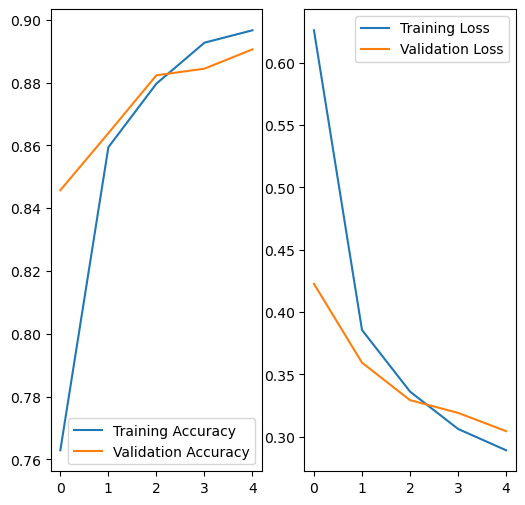

In [24]:
# results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show();


In [30]:
import pickle

model.save('resnet50.keras')

with open('resnet50_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
